In [3]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime
from netCDF4 import Dataset


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat,upslope_omega_sin
from orographicPrecipitation.precip_extremes_scaling import *
from wrfProcessing import *

import warnings
from tabulate import tabulate

In [4]:
def sel_crosseqtropicmountain(ds):
    return ds.sel(west_east=slice(38,41),south_north=slice(64,75))

tropics_limit=5

def mean_mountain(x):
    return sel_crosseqtropicmountain(x).mean(['west_east','south_north'])
def mean_upslope(x):
    return x.sel(west_east=slice(39,41),south_north=slice(64,75)).mean(['west_east','south_north'])
def mean_lee(x):
    return x.sel(west_east=slice(37,39),south_north=slice(64,75)).mean(['west_east','south_north'])
def mean_rest_tropics(x):
    return x.sel(west_east=((x.west_east<20)|(x.west_east>60)),south_north=slice(70-tropics_limit,70+tropics_limit)).mean(['west_east','south_north'])

def mean_tropics(x):
    return x.sel(south_north=slice(70-tropics_limit,70+tropics_limit)).mean(['west_east','south_north'])
def mean_midlatitudes(x):
    return x.sel(south_north=(((x.south_north>=70-60)&(x.south_north<70-40))|((x.south_north>=70+40)&(x.south_north<70+60)))).mean(['west_east','south_north'])
                 

In [5]:
def hemi_average(ds):
    return (ds.isel(south_north=range(69,-1,-1))+ds.isel(south_north=range(70,140)))/2

In [7]:


with warnings.catch_warnings():
    warnings.simplefilter("ignore",FutureWarning)
    
    Mcont = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","new.wrf.crosseq.mountain.100km.300d"              ,"Mountain, control"         ,sel_crosseqtropicmountain,"orange",open_ds=1,shifttimes=0)
    Mwarm = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","new.wrf.crosseq.mountain.100km.SST2K_2XCO2.300d"  ,"Mountain, SST +2K, 2*CO2"  ,sel_crosseqtropicmountain,"red",open_ds=1,shifttimes=0)
    Acont = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","new.wrf.crosseq.aquaplanet.100km.300d"              ,"Aquaplanet, control"         ,sel_crosseqtropicmountain,"dodgerblue",open_ds=1,shifttimes=0)
    Awarm = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","new.wrf.crosseq.aquaplanet.100km.SST2K_2XCO2.300d"  ,"Aquaplanet, SST +2K, 2*CO2"  ,sel_crosseqtropicmountain,"blue",open_ds=1,shifttimes=0)
    Icont = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","new.wrf.crosseq.flatisland.100km.300d"  ,"Flat Island"  ,sel_crosseqtropicmountain,"green",open_ds=1,shifttimes=0)
        

loading time : 1.0 s
Daily precips already computed
precips time : 0.0 s
loading time : 1.1 s
Daily precips already computed
precips time : 0.0 s
loading time : 1.0 s
Daily precips already computed
precips time : 0.0 s
loading time : 17.7 s
precips time : 40.6 s
loading time : 17.8 s
Daily precips already computed
precips time : 0.2 s


In [24]:
def set_pctile(pctile):
    for ds in [Mcont,Mwarm,Icont,Acont,Awarm]:
        ds.set_extreme_precip(pctile/100)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore",RuntimeWarning)
            warnings.simplefilter("ignore",FutureWarning)
            ds.set_extreme_vars(pctile/100)
            ds.compute_ogscaling()

In [25]:
pctile=95
set_pctile(pctile)

In [10]:
for ds in [Mcont,Mwarm,Icont,Acont,Awarm]:
    precip_dailyconcat = xr.concat([ds.precip_daily.isel(south_north=range(69,-1,-1)),ds.precip_daily.isel(south_north=range(70,140))],"time")
    ds.ex_pr_2 = precip_dailyconcat.chunk({'time': -1}).quantile(0.95,"time")
    ds.ex_pr_zonmean_2 = ds.ex_pr_2.mean('west_east')


In [11]:
def extract_rains(ds):
    rainc=ds.RAINC.sel(Time=slice(200,len(ds.Time))).diff('Time').mean("Time")*4
    rainnc=ds.RAINNC.sel(Time=slice(200,len(ds.Time))).diff('Time').mean("Time")*4
    return rainc,rainnc,rainc+rainnc

In [5]:
end=8

test_USGS=xr.open_mfdataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/WRF/USGS_65_100/wrfout_d01_1970-*")),combine="nested",concat_dim='Time')
rainc_USGS,rainnc_USGS,rain_USGS = extract_rains(test_USGS)

test_USGSnew=xr.open_mfdataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/WRF/USGS_39_180/wrfout_d01_1970-*")),combine="nested",concat_dim='Time')
rainc_USGSnew,rainnc_USGSnew,rain_USGSnew = extract_rains(test_USGSnew)

test_USGS2=xr.open_mfdataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/WRF/USGS_65_100_2/wrfout_d01_1970-*")),combine="nested",concat_dim='Time')
rainc_USGS2,rainnc_USGS2,rain_USGS2 = extract_rains(test_USGS2)

test_USGS3=xr.open_mfdataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/WRF/WRFV4_USGS/test/em_beta_plane/wrfout_d01_1970-*")),combine="nested",concat_dim='Time')
rainc_USGS3,rainnc_USGS3,rain_USGS3 = extract_rains(test_USGS3)

# XLand / RH Checks

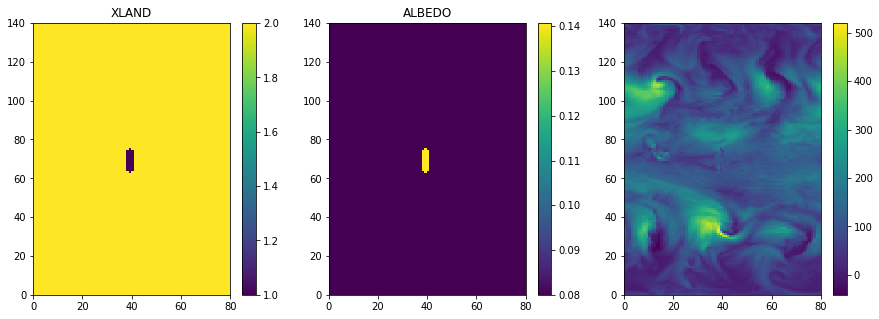

In [6]:
test=xr.open_dataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.mountain.100km.300d/wrfout_d01_1970-*"))[-1])
def plot_2dvar(var,ax):
    c = ax.pcolormesh(np.array(var))
    plt.colorbar(c,ax=ax)
    ax.set_title(var.name)
    
_,ax=plt.subplots(1,3,figsize=(15,5))
plot_2dvar(test.XLAND.isel(Time=30),ax[0])
plot_2dvar(test.ALBEDO.isel(Time=30),ax[1])
plot_2dvar((test.HFX+test.LH).isel(Time=30),ax[2])


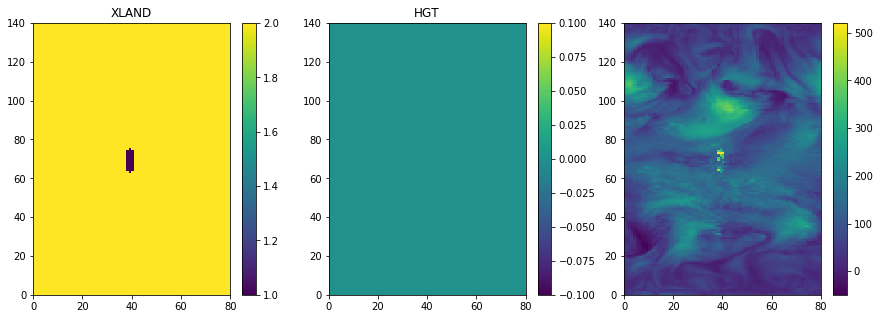

In [15]:
test=xr.open_dataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.flatisland.100km.300d/wrfout_d01_1970-*"))[-2])

_,ax=plt.subplots(1,3,figsize=(15,5))
plot_2dvar(test.XLAND.isel(Time=30),ax[0])
plot_2dvar(test.HGT.isel(Time=30),ax[1])
plot_2dvar((test.HFX+test.LH).isel(Time=30),ax[2])

In [49]:
q2m = Acont.vars.q_2m.mean('time')
T2m = Acont.vars.T_2m.mean('time')
rh = 100*q2m/qsat(T2m+273.15,1e3)

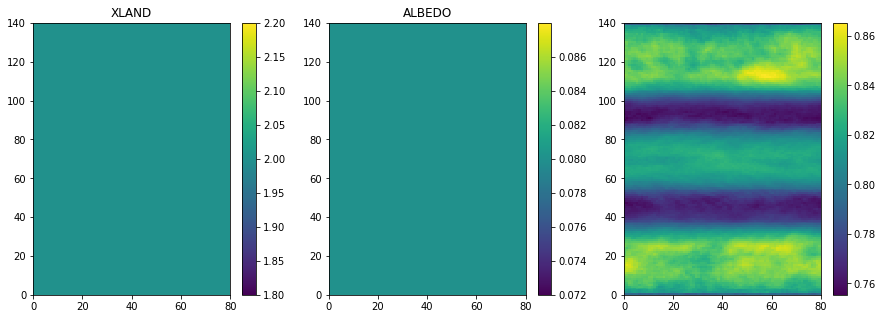

In [39]:
test=xr.open_dataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.aquaplanet.100km.300d/wrfout_d01_1970-*"))[-2])

_,ax=plt.subplots(1,3,figsize=(15,5))
plot_2dvar(test.XLAND.isel(Time=30),ax[0])
plot_2dvar(test.ALBEDO.isel(Time=30),ax[1])
plot_2dvar(rh,ax[2])

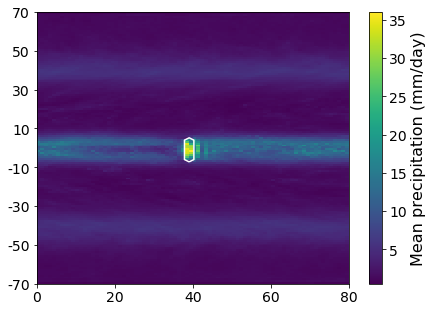

In [50]:
_,ax=plt.subplots(1,1,figsize=(7,5))

hgt = test.HGT.isel(Time=30)
pr = ds.precip_daily.mean('time')
c = ax.pcolormesh(np.array(pr))
cbar = plt.colorbar(c,ax=ax)
cbar.set_label("Mean precipitation (mm/day)",size=16)
cbar.ax.tick_params(labelsize=14) 
ax.contour(hgt,levels=[100.],colors=['w'])
ax.set_yticks(np.arange(0,141,20))
ax.set_yticklabels(np.arange(-70,71,20),size=14)
ax.tick_params(axis='both', which='major', labelsize=14)
None

In [45]:
q2m = test_USGS.Q2.mean('Time')
T2m = test_USGS.T2.mean('Time')
rhUSGS = 100*q2m/qsat(T2m,1e3)

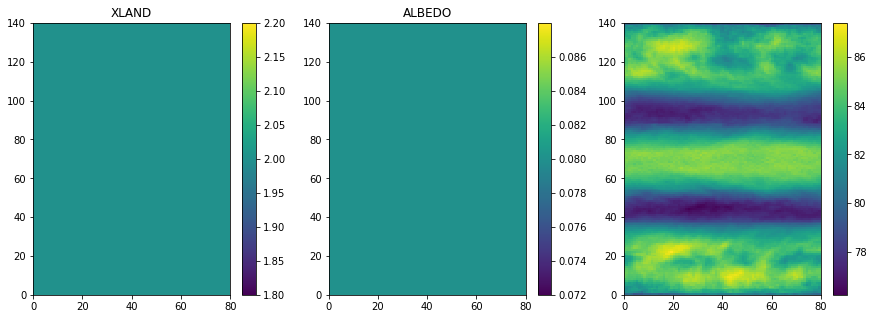

In [42]:
_,ax=plt.subplots(1,3,figsize=(15,5))
plot_2dvar(test_USGS.XLAND.isel(Time=30),ax[0])
plot_2dvar(test_USGS.ALBEDO.isel(Time=30),ax[1])
plot_2dvar(rhUSGS,ax[2])

# Surface temp / soil moisture diurnal cycle over mountain / flat island

In [55]:
mt=xr.open_mfdataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.mountain.100km.300d/wrfout_d01_1970-*"))[2:],combine="nested",concat_dim='Time')
ft=xr.open_mfdataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.flatisland.100km.300d/wrfout_d01_1970-*"))[2:],combine="nested",concat_dim='Time')


In [64]:
for v in list(mt.variables)[1:]:
    print(v, mt[v].description)


XLAT LATITUDE, SOUTH IS NEGATIVE
XLONG LONGITUDE, WEST IS NEGATIVE
LU_INDEX LAND USE CATEGORY
ZNU eta values on half (mass) levels
ZNW eta values on full (w) levels
U x-wind component
V y-wind component
W z-wind component
PH perturbation geopotential
PHB base-state geopotential
T perturbation potential temperature theta-t0
THM either 1) pert moist pot temp=(1+Rv/Rd Qv)*(theta)-T0, or 2) pert dry pot temp=t
MU perturbation dry air mass in column
MUB base state dry air mass in column
P perturbation pressure
PB BASE STATE PRESSURE
RHO DENSITY
THIS_IS_AN_IDEAL_RUN T/F flag: this is an ARW ideal simulation
P_HYD hydrostatic pressure
Q2 QV at 2 M
T2 TEMP at 2 M
TH2 POT TEMP at 2 M
PSFC SFC PRESSURE
U10 U at 10 M
V10 V at 10 M
RDX INVERSE X GRID LENGTH
RDY INVERSE Y GRID LENGTH
ZETATOP ZETA AT MODEL TOP
ITIMESTEP 
XTIME minutes since 1970-01-01 00:00:00
QVAPOR Water vapor mixing ratio
QCLOUD Cloud water mixing ratio
QRAIN Rain water mixing ratio
QICE Ice mixing ratio
QSNOW Snow mixing ratio
Q

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore

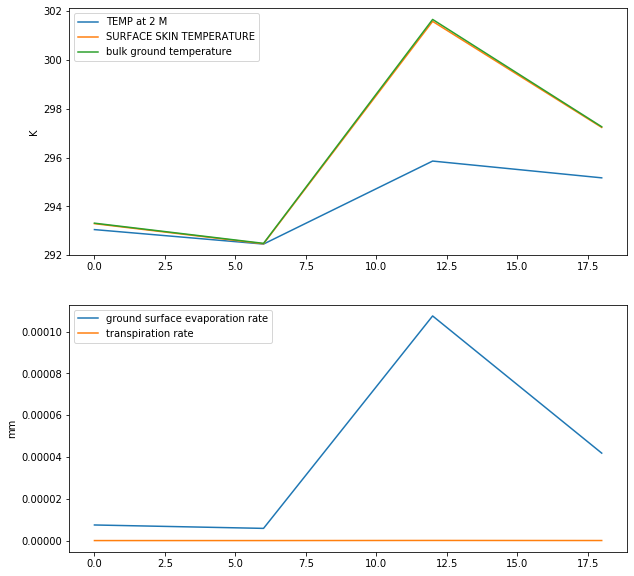

In [80]:
_,ax=plt.subplots(2,1,figsize=(10,10))
for var in ["T2","TSK","TG"]:
    ax[0].plot(range(0,24,6),mean_mountain(mt[var].groupby('XTIME.hour').mean()),label=mt[var].description)
for var in ["EDIR","ETRAN"]:
    ax[1].plot(range(0,24,6),mean_mountain(mt[var].groupby('XTIME.hour').mean()),label=mt[var].description)

ax[0].set_ylabel("K")
ax[1].set_ylabel("mm")
ax[0].legend()
ax[1].legend()

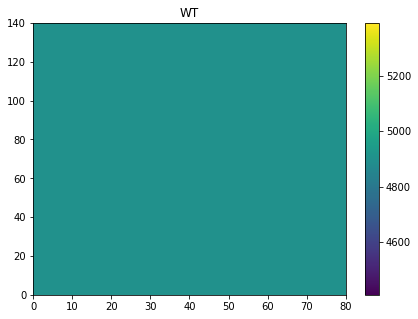

In [83]:
_,ax=plt.subplots(1,1,figsize=(7,5))
plot_2dvar(mt.WT.mean("Time"),ax)

# Mountain VS Aquaplanet VS Flat Island

## Zonal Mean Precipitation

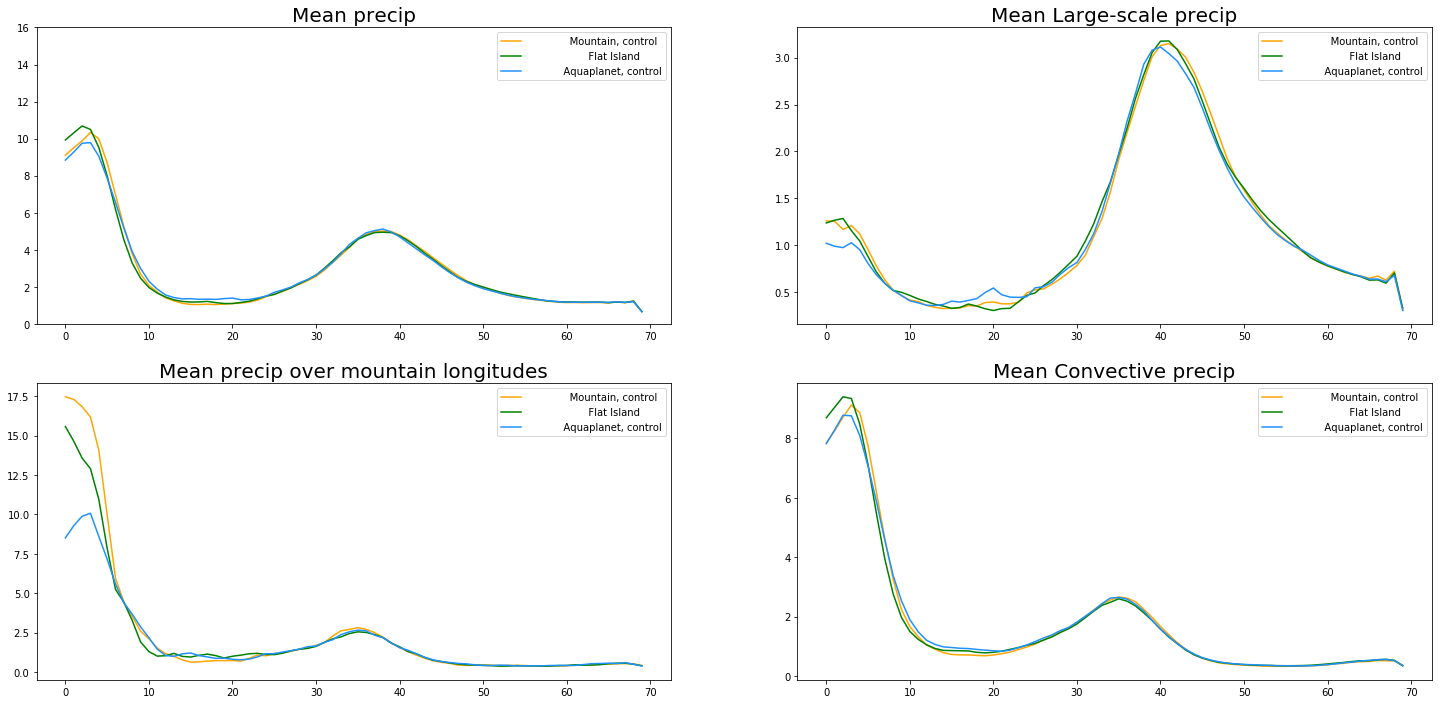

In [12]:
fig, ax = plt.subplots(2,2,figsize=(25,2*6))
ax = ax.reshape(-1)

i=0
for ds in [Mcont,Icont,Acont]:
    ax[0].plot(range(70),hemi_average(ds.precip_daily.mean(["time","west_east"])  ),label="{:>30}".format(ds.lbl),color=ds.color)
    ax[1].plot(range(70),hemi_average(ds.precip_g_daily.mean(["time","west_east"])),label="{:>30}".format(ds.lbl),color=ds.color)
    ax[3].plot(range(70),hemi_average(ds.precip_c_daily.mean(["time","west_east"])),label="{:>30}".format(ds.lbl),color=ds.color)
    ax[2].plot(range(70),hemi_average(ds.precip_c_daily.sel(west_east=slice(38,41)).mean(["time","west_east"])),label="{:>30}".format(ds.lbl),color=ds.color)
    i+=1

ax[0].set_title("Mean precip",fontsize=20)
ax[1].set_title("Mean Large-scale precip",fontsize=20)
ax[3].set_title("Mean Convective precip",fontsize=20)
ax[2].set_title("Mean precip over mountain longitudes",fontsize=20)
ax[0].set_ylim(0,16)

for a in ax :a.legend()

## 2D time mean precipitation

In [13]:
from scipy import stats
def ttest_1samp(a, popmean, dim):
    """
    (quentin) taken here : https://gist.github.com/kuchaale/293d2a16726a5d492be4f5bbae8d9111
    """
    n = 2#a[dim].shape[0]
    df = (n-1)
    print(df)
    a_mean = a.mean(dim)
    #d = a_mean - popmean
    #v = a.var(dim, ddof=1)
    #denom = xr.ufuncs.sqrt(v / float(n))
#
    #t = d /denom
    #prob = stats.distributions.t.sf(xr.ufuncs.fabs(t), df) * 2
    #prob_xa = xr.DataArray(prob, coords=a_mean.coords)
    prob_xa=0.03
    return a_mean, prob_xa


In [14]:
mtn=xr.open_dataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.mountain.100km.300d/wrfout_d01_1970-*"))[-1]).HGT.isel(Time=0)
mtn=hemi_average(mtn)

In [15]:
scale = 20
def plot_2dvar(var,ax):
    c = ax.pcolormesh(np.array(var),cmap=plt.cm.RdBu_r,vmin=-scale,vmax=scale)
    plt.colorbar(c,ax=ax)
    mtn.plot.contour(ax=ax,**{'levels':[200.]})

def plot_diff(ds1,ds2,ax):
    diff = hemi_average(ds1 - ds2)
    diff, pval = ttest_1samp(diff, 0, "time")
    plot_2dvar(diff*(pval < 0.05),ax)

1
1
1


Text(0.5, 1.0, 'Mountain - flat island')

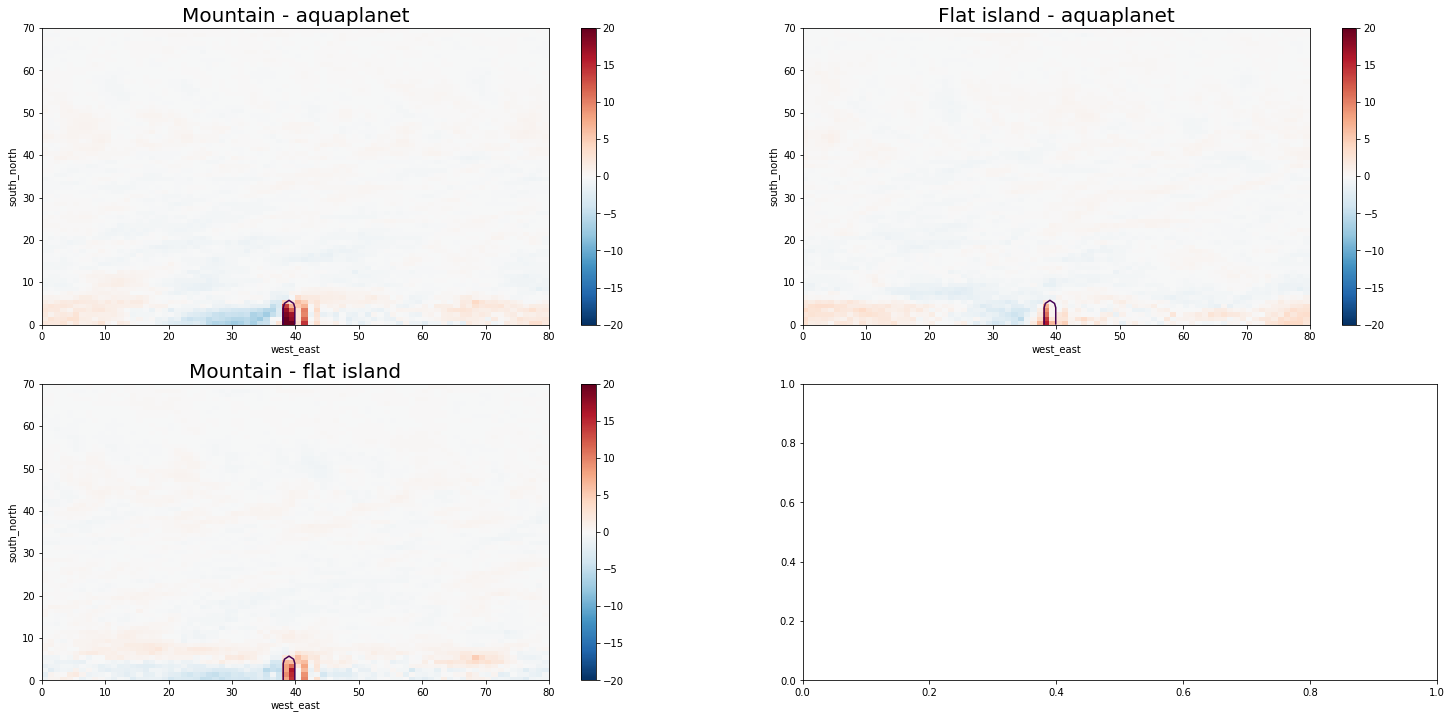

In [16]:
fig, ax = plt.subplots(2,2,figsize=(25,2*6))
ax = ax.reshape(-1)

plot_diff(Mcont.precip_daily,Acont.precip_daily,ax[0])
plot_diff(Icont.precip_daily,Acont.precip_daily,ax[1])
plot_diff(Mcont.precip_daily,Icont.precip_daily,ax[2])

ax[0].set_title("Mountain - aquaplanet",fontsize=20)
ax[1].set_title("Flat island - aquaplanet",fontsize=20)
ax[2].set_title("Mountain - flat island",fontsize=20)

## Precipitation extremes

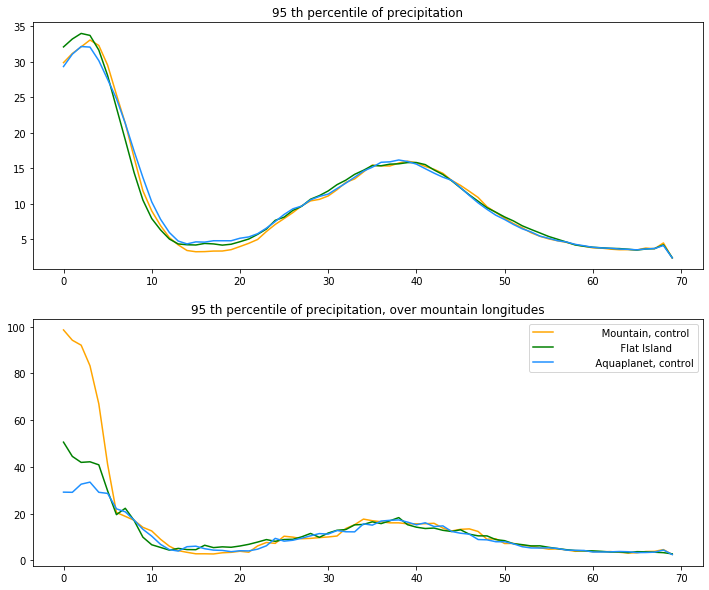

In [17]:
fig, ax = plt.subplots(2,1,figsize=(12,10))
i=0

for ds in [Mcont,Icont,Acont]:
    if i==1:
        i+=1
    ax[0].plot(range(70),hemi_average(ds.ex_pr_zonmean),  label="{:>30}".format(ds.lbl)  ,color=ds.color)
    ax[1].plot(range(70),hemi_average(ds.ex_pr.sel(west_east=slice(38,40)).mean("west_east")),label="{:>30}".format(ds.lbl),color=ds.color)
    i+=1

ax[0].set_title("%i th percentile of precipitation"%pctile)
ax[1].set_title("%i th percentile of precipitation, over mountain longitudes"%pctile)
plt.legend()

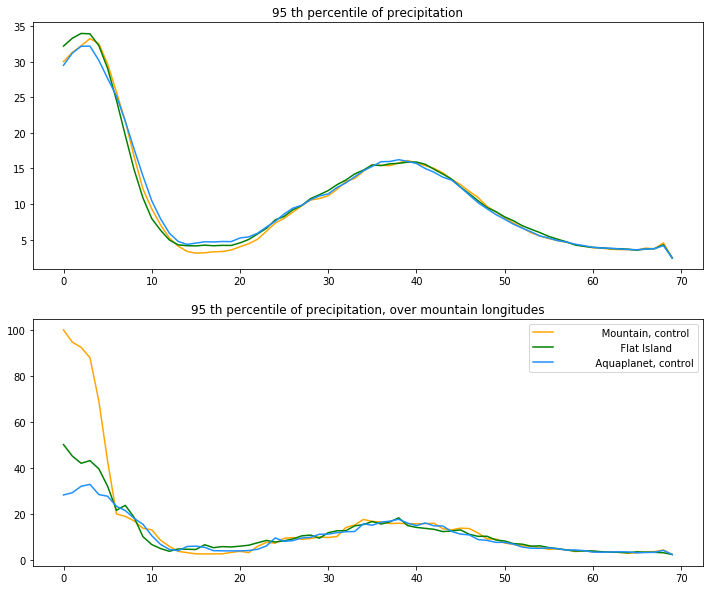

In [18]:
fig, ax = plt.subplots(2,1,figsize=(12,10))
i=0

for ds in [Mcont,Icont,Acont]:
    if i==1:
        i+=1
    ax[0].plot(range(70),ds.ex_pr_zonmean_2,  label="{:>30}".format(ds.lbl)  ,color=ds.color)
    ax[1].plot(range(70),ds.ex_pr_2.sel(west_east=slice(38,40)).mean("west_east"),label="{:>30}".format(ds.lbl),color=ds.color)
    i+=1

ax[0].set_title("%i th percentile of precipitation"%pctile)
ax[1].set_title("%i th percentile of precipitation, over mountain longitudes"%pctile)
plt.legend()

# Warm Mountain/Aquaplanet vs Control Mountain/Aquaplanet

In [19]:
print("Mean precip increase, Mountain simulation : %.2f%%/K"%  (100*(spatial_mean(Mwarm.precip_daily.mean("time"))/spatial_mean(Mcont.precip_daily.mean("time")) - 1)))
print("Mean precip increase, Aquaplanet simulation : %.2f%%/K"%(100*(spatial_mean(Awarm.precip_daily.mean("time"))/spatial_mean(Acont.precip_daily.mean("time")) - 1)))


Mean precip increase, Mountain simulation : 4.92%/K
Mean precip increase, Aquaplanet simulation : 5.09%/K


## Zonal-mean precipitation

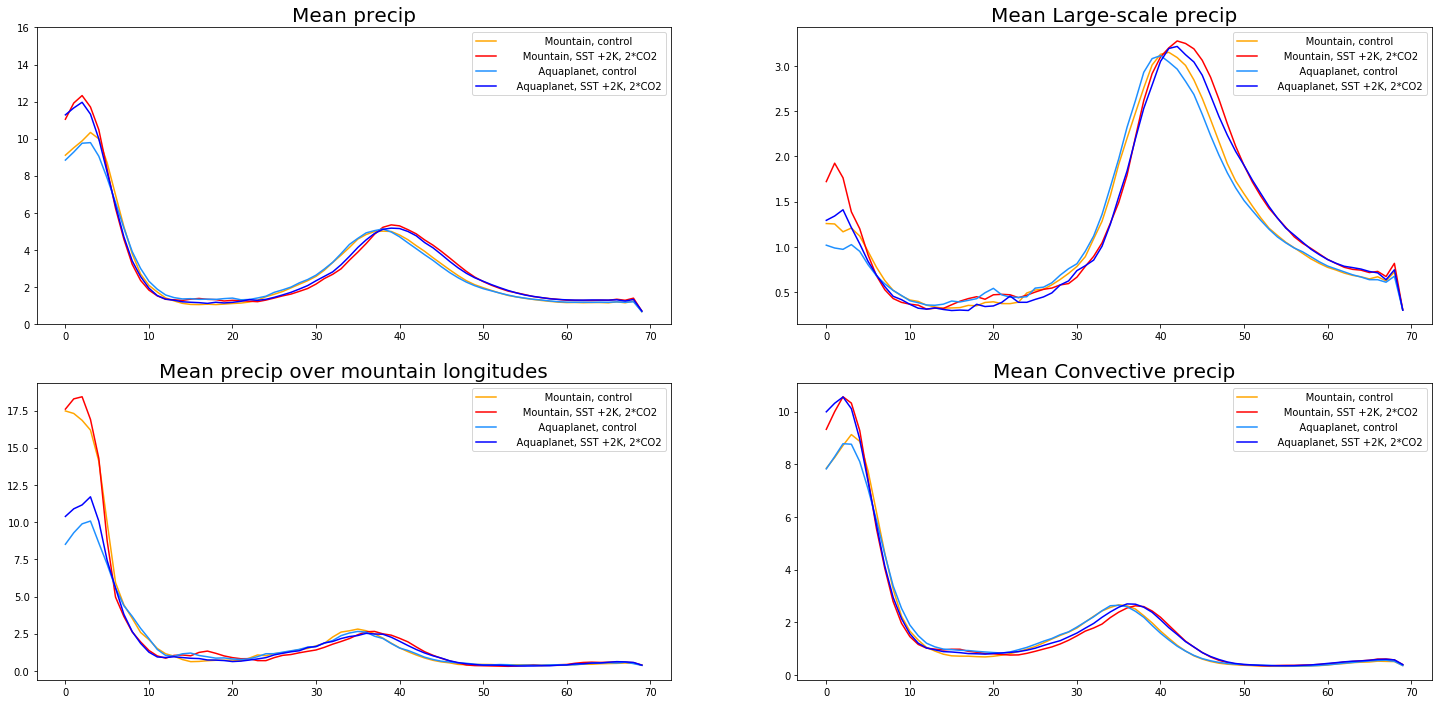

In [20]:
fig, ax = plt.subplots(2,2,figsize=(25,2*6))
ax = ax.reshape(-1)

i=0
for ds in [Mcont,Mwarm,Acont,Awarm]:
    ax[0].plot(range(70),hemi_average(ds.precip_daily.mean(["time","west_east"])  ),label="{:>30}".format(ds.lbl),color=ds.color)
    ax[1].plot(range(70),hemi_average(ds.precip_g_daily.mean(["time","west_east"])),label="{:>30}".format(ds.lbl),color=ds.color)
    ax[3].plot(range(70),hemi_average(ds.precip_c_daily.mean(["time","west_east"])),label="{:>30}".format(ds.lbl),color=ds.color)
    ax[2].plot(range(70),hemi_average(ds.precip_c_daily.sel(west_east=slice(38,41)).mean(["time","west_east"])),label="{:>30}".format(ds.lbl),color=ds.color)
    i+=1

ax[0].set_title("Mean precip",fontsize=20)
ax[1].set_title("Mean Large-scale precip",fontsize=20)
ax[3].set_title("Mean Convective precip",fontsize=20)
ax[2].set_title("Mean precip over mountain longitudes",fontsize=20)
ax[0].set_ylim(0,16)

for a in ax :a.legend()

## 2D time mean precipitation

1


Text(0.5, 1.0, 'Warm Mountain - Control mountain')

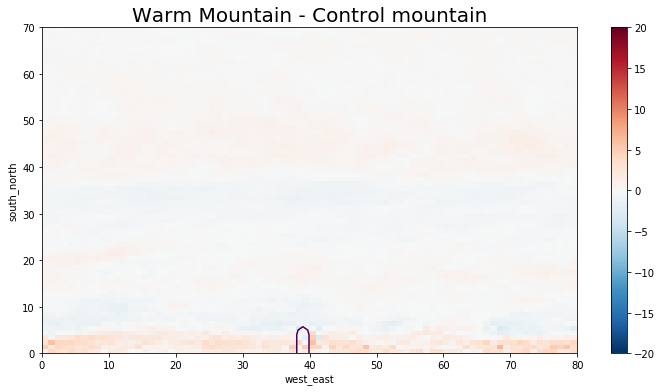

In [21]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
plot_diff(Mwarm.precip_daily,Mcont.precip_daily,ax)
ax.set_title("Warm Mountain - Control mountain",fontsize=20)

Text(0.5, 1.0, 'Warm Mountain - Control mountain')

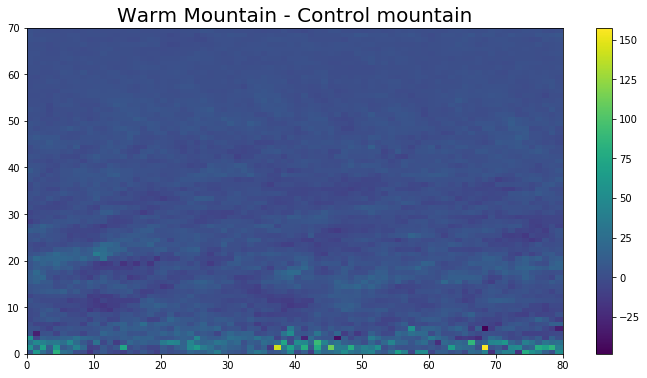

In [41]:
def plot_2dvar(var,ax):
    c = ax.pcolormesh(np.array(var))
    plt.colorbar(c,ax=ax)
    ax.set_title(var.name)
def plot_diff(ds1,ds2,ax):
    diff = hemi_average(ds1 - ds2)
    plot_2dvar(diff,ax)
fig, ax = plt.subplots(1,1,figsize=(12,6))
plot_diff(Mwarm.ex_pr,Mcont.ex_pr,ax)
ax.set_title("Warm Mountain - Control mountain",fontsize=20)

## Precipitation extremes

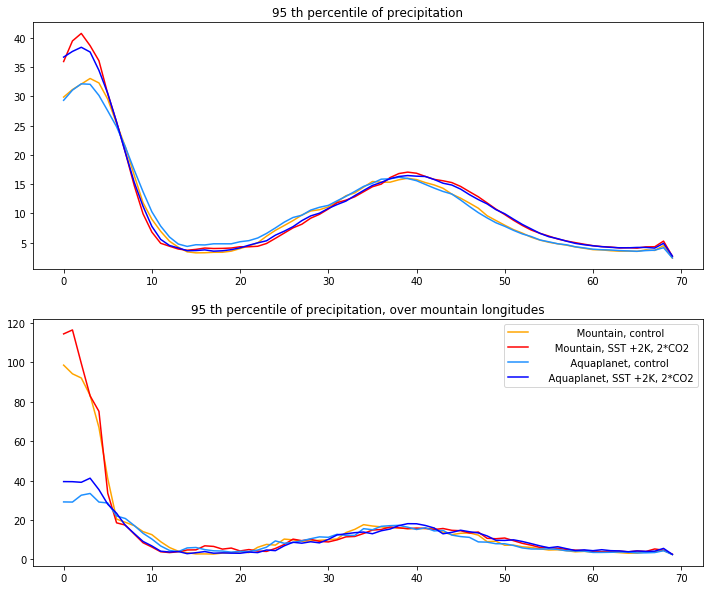

In [32]:
fig, ax = plt.subplots(2,1,figsize=(12,10))

for ds in [Mcont,Mwarm,Acont,Awarm]:
    ax[0].plot(range(70),hemi_average(ds.ex_pr_zonmean),  label="{:>30}".format(ds.lbl)  ,color=ds.color)
    ax[1].plot(range(70),hemi_average(ds.ex_pr.sel(west_east=slice(38,40)).mean("west_east")),label="{:>30}".format(ds.lbl),color=ds.color)

ax[0].set_title("%i th percentile of precipitation"%pctile)
ax[1].set_title("%i th percentile of precipitation, over mountain longitudes"%pctile)
plt.legend()

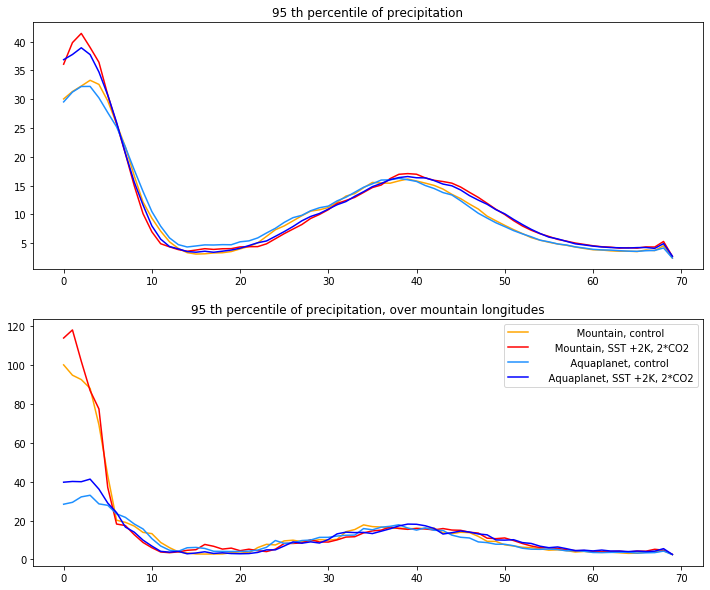

In [33]:
fig, ax = plt.subplots(2,1,figsize=(12,10))
i=0

for ds in [Mcont,Mwarm,Acont,Awarm]:
    if i==1:
        i+=1
    ax[0].plot(range(70),ds.ex_pr_zonmean_2,  label="{:>30}".format(ds.lbl)  ,color=ds.color)
    ax[1].plot(range(70),ds.ex_pr_2.sel(west_east=slice(38,40)).mean("west_east"),label="{:>30}".format(ds.lbl),color=ds.color)
    i+=1

ax[0].set_title("%i th percentile of precipitation"%pctile)
ax[1].set_title("%i th percentile of precipitation, over mountain longitudes"%pctile)
plt.legend()

## Extreme precipitation sensitivity

In [28]:
for ds in [Mcont,Mwarm]:
    precip_dailyconcat = xr.concat([ds.precip_daily.isel(south_north=range(69,-1,-1)),ds.precip_daily.isel(south_north=range(70,140))],"time")
    precip_dailyconcatbis = xr.concat([precip_dailyconcat.isel(west_east=i) for i in range(80)],"time")
    ds.ex_pr_zonmean_3 = precip_dailyconcatbis.chunk({'time': -1}).quantile(0.95,"time")


Text(0.5, 0.98, 'Sensitivity of the 95 th pctile of precip, %/(K of global mean temperature) AVERAGED OVER BOTH HEMISPHERES')

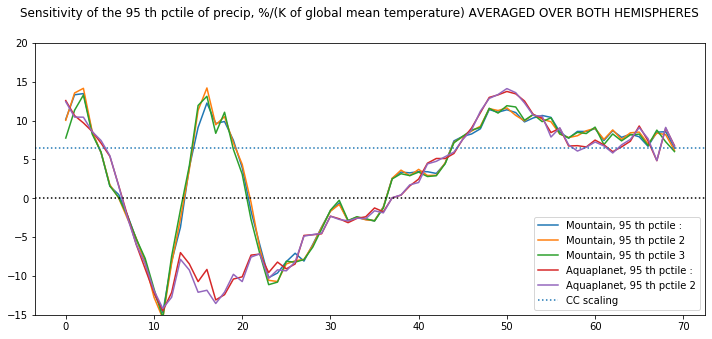

In [30]:
Mwarm_ex_pr = (Mwarm.ex_pr_zonmean[69::-1]+Mwarm.ex_pr_zonmean[70:])/2
Mcont_ex_pr = (Mcont.ex_pr_zonmean[69::-1]+Mcont.ex_pr_zonmean[70:])/2         
           
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(range(70),100*(hemi_average(Mwarm.ex_pr_zonmean)/hemi_average(Mcont.ex_pr_zonmean) - 1)/2, label = "Mountain, %i th pctile : "%pctile)
ax.plot(range(70),100*(Mwarm.ex_pr_zonmean_2/Mcont.ex_pr_zonmean_2 - 1)/2, label = "Mountain, %i th pctile 2"%pctile)
ax.plot(range(70),100*(Mwarm.ex_pr_zonmean_3/Mcont.ex_pr_zonmean_3 - 1)/2, label = "Mountain, %i th pctile 3"%pctile)
           
ax.plot(range(70),100*(hemi_average(Awarm.ex_pr_zonmean)/hemi_average(Acont.ex_pr_zonmean) - 1)/2, label = "Aquaplanet, %i th pctile : "%pctile)
ax.plot(range(70),100*(Awarm.ex_pr_zonmean_2/Acont.ex_pr_zonmean_2 - 1)/2, label = "Aquaplanet, %i th pctile 2"%pctile)

ax.axhline(6.5,linestyle=":",label="CC scaling")
ax.axhline(0.,linestyle=":",color="k")

ax.set_ylim(-15,20)

plt.legend()
fig.suptitle("Sensitivity of the %i th pctile of precip, %%/(K of global mean temperature) AVERAGED OVER BOTH HEMISPHERES"%pctile)

## Sensitivity breakdown (Fildier et al 2017)

In [34]:
def bsensitivity_breakdown(cont,warm,pctile,mean_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=1):
    meanTinc=2
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",category=RuntimeWarning)
                      
        prsensm  = bPR(cont,warm,meanTinc,mean_mountain    )
        prsensl  = bPR(cont,warm,meanTinc,mean_lee         )
        prsenst  = bPR(cont,warm,meanTinc,mean_tropics     )
        #prsenss  = bPR(cont,warm,meanTinc,mean_subtropics  )
        prsense  = bPR(cont,warm,meanTinc,mean_midlatitudes)
        
        em  = bE(cont,warm,meanTinc,mean_mountain    )
        el  = bE(cont,warm,meanTinc,mean_lee         )
        et  = bE(cont,warm,meanTinc,mean_tropics     )
        #es  = bE(cont,warm,meanTinc,mean_subtropics  )
        ee  = bE(cont,warm,meanTinc,mean_midlatitudes)
        
        d1m  = bD1(cont,warm,meanTinc,mean_mountain    )
        d1l  = bD1(cont,warm,meanTinc,mean_lee         )
        d1t  = bD1(cont,warm,meanTinc,mean_tropics     )
        #d1s  = bD1(cont,warm,meanTinc,mean_subtropics  )
        d1e  = bD1(cont,warm,meanTinc,mean_midlatitudes)
        
        d2m  = bD2(cont,warm,meanTinc,mean_mountain    )
        d2l  = bD2(cont,warm,meanTinc,mean_lee         )
        d2t  = bD2(cont,warm,meanTinc,mean_tropics     )
        #d2s  = bD2(cont,warm,meanTinc,mean_subtropics  )
        d2e  = bD2(cont,warm,meanTinc,mean_midlatitudes)
        
        thm  = bT(cont,warm,meanTinc,mean_mountain    )
        thl  = bT(cont,warm,meanTinc,mean_lee         )
        tht  = bT(cont,warm,meanTinc,mean_tropics     )
        #ths  = bT(cont,warm,meanTinc,mean_subtropics  )
        the  = bT(cont,warm,meanTinc,mean_midlatitudes)
        
    print(' '*30+'\033[1m'+ "Extreme precip sensitivity breakdown, %i th percentile"%pctile + '\033[0m')
    
    tab=[['Tropics - 0°-%i°'%tropics_limit ,"%.2f"%(100*prsenst),"%.2f"%(100*et),"%.2f"%(100*d1t),"%.2f"%(100*d2t),"%.2f"%(100*tht),"%.2f"%(100*(prsenst-et-d1t-d2t-tht))],
         ['Midlatitudes - 40°-60°',         "%.2f"%(100*prsense),"%.2f"%(100*ee),"%.2f"%(100*d1e),"%.2f"%(100*d2e),"%.2f"%(100*the),"%.2f"%(100*(prsense-ee-d1e-d2e-the))],
        ]
    if mountain :
        tab += [['Mountain - whole',"%.2f"%(100*prsensm),"%.2f"%(100*em),"%.2f"%(100*d1m),"%.2f"%(100*d2m),"%.2f"%(100*thm),"%.2f"%(100*(prsensm-em-d1m-d2m-thm))],
                ['Mountain - Lee',           "%.2f"%(100*prsensl),"%.2f"%(100*el),"%.2f"%(100*d1l),"%.2f"%(100*d2l),"%.2f"%(100*thl),"%.2f"%(100*(prsensl-el-d1l-d2l-thl))],
               ]
    
    print(tabulate(tab, headers=['Region', 'Precip (%)', 'Efficiency (%)', 'D1 (%)', 'D2 (%)', 'T (%)', 'N (%)']))


In [35]:
print("Tropics Mountain")
t=time.time()
bsensitivity_breakdown(Mcont,Mwarm,pctile,mean_rest_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=1)
print(time.time()-t)
print("Aquaplanet")
t=time.time()
bsensitivity_breakdown(Acont,Awarm,pctile,mean_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=0)
print(time.time()-t)

Tropics Mountain
                              Extreme precip sensitivity breakdown, 95 th percentile
Region                    Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
----------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°                 8.94             -0.61      5.34     -1.52     7.49    -1.76
Midlatitudes - 40°-60°          7.51              0.38      1.45     -0.83     7.6     -1.09
Mountain - whole                6.62             -0.01      1.78     -0.45     6.89    -1.59
Mountain - Lee                  7.26              2.89     -0.62      0.34     7.43    -2.77
184.60837411880493
Aquaplanet
                              Extreme precip sensitivity breakdown, 95 th percentile
Region                    Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
----------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°                 9.71   

In [37]:
pctile=99
set_pctile(pctile)

In [38]:
print("Tropics Mountain")
t=time.time()
bsensitivity_breakdown(Mcont,Mwarm,pctile,mean_rest_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=1)
print(time.time()-t)
print("Aquaplanet")
t=time.time()
bsensitivity_breakdown(Acont,Awarm,pctile,mean_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=0)
print(time.time()-t)

Tropics Mountain
                              Extreme precip sensitivity breakdown, 99 th percentile
Region                    Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
----------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°                14.06             -0.59      8.93     -0.63     7.03    -0.67
Midlatitudes - 40°-60°          6.09              0.4       0.31     -0.41     7.04    -1.26
Mountain - whole               13.51              1.4       6.39     -0.25     6.78    -0.82
Mountain - Lee                 17.89              2.39      8.81     -0.18     7.11    -0.24
182.37304615974426
Aquaplanet
                              Extreme precip sensitivity breakdown, 99 th percentile
Region                    Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
----------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°                12.65   

# Vertical motion profiles over tropics/mountains/midlatitudes on precip extremes days

No handles with labels found to put in legend.
No handles with labels found to put in legend.


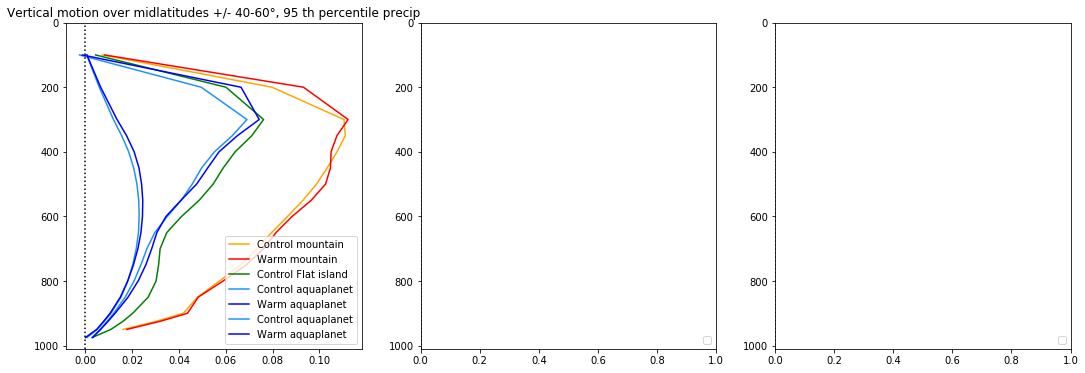

In [36]:
fig, ax = plt.subplots(1,3,figsize=(18,6))


with warnings.catch_warnings():
    warnings.simplefilter("ignore",category=RuntimeWarning)
    ax[0].plot(mean_mountain(Mcont.ex_w),Mcont.ex_w.level,label="Control mountain",color=Mcont.color)
    ax[0].plot(mean_mountain(Mwarm.ex_w),Mwarm.ex_w.level,label="Warm mountain"   ,color=Mwarm.color)
    ax[0].plot(mean_mountain(Icont.ex_w),Icont.ex_w.level,label="Control Flat island",color=Icont.color)
    ax[0].set_title("Vertical motion over mountain, %i th percentile precip"%pctile)

    ax[1].plot(mean_tropics(Acont.ex_w),Acont.ex_w.level,label="Control aquaplanet",color=Acont.color)
    ax[1].plot(mean_tropics(Awarm.ex_w),Awarm.ex_w.level,label="Warm aquaplanet"   ,color=Awarm.color)
    ax[1].set_title("Vertical motion over tropics -5-5°, %i th percentile precip"%pctile)

    ax[2].plot(mean_midlatitudes(Acont.ex_w),Acont.ex_w.level,label="Control aquaplanet",color=Acont.color)
    ax[2].plot(mean_midlatitudes(Awarm.ex_w),Awarm.ex_w.level,label="Warm aquaplanet"   ,color=Awarm.color)
    ax[2].set_title("Vertical motion over midlatitudes +/- 40-60°, %i th percentile precip"%pctile)

for a in ax:
    a.axvline(0,linestyle=':',color='k')
    a.legend(loc='lower right')
    a.set_ylim(1010,0)
    

